<a href="https://colab.research.google.com/github/ckevar/Conv4MammographyAbnormalities/blob/main/Scratch_CNN_2classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Mounting Drive
In this Notebok, a 2-class classifier is built from scratch to discriminate between **Mass** or **Calcification** in a mammography.


In this section, all libraries that are necesseray for training are includded here, alongside google drive mounting the root files

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
import os

import requests

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import output
from google.colab import drive

# Mounts Drive
drive.mount("/content/gdrive")
base_path = "/content/gdrive/My Drive/CI_proj/"
metrics_path = base_path+"metrics/"

Mounted at /content/gdrive


# Loading Data
The data that is usefull for training only

In [ ]:
img = np.load(base_path+'dataset/train_tensor.npy') 
labels = np.load(base_path+'dataset/train_labels.npy') 
depth, width, height = img.shape # shape of the train label depth_val, width_val, height_val = images_val.shape # shape of the train label
classLabel = ["Mass", "Calcification"]

## Data Processing: Masses and Clasification
Since it is a binary classification, the vector labels_train will hold the values 0: Masses and 1: Calcifications.

In [ ]:
labels_train = np.array([]);
idx = [];

for i in range(depth):
  if ((labels[i] == 1) or (labels[i] == 2)): # mass
    idx.append(i)
    labels_train = np.append(labels_train, [0])

  elif ((labels[i] == 3) or (labels[i] == 4)): # calcification
    idx.append(i)
    labels_train = np.append(labels_train, [1]);

img = img[idx];
depth = idx.__len__()

## Plotting some of the data
Four samples are plotted randomly, just to visual verification. 

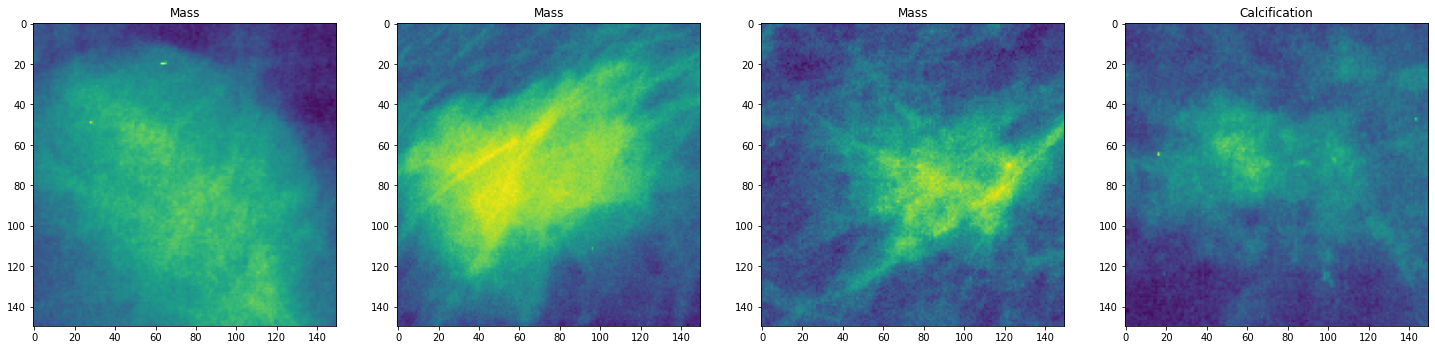

In [ ]:
toPlot = np.random.randint(depth, size = 4)

plt.figure(figsize=(25, 10))
for x in range(toPlot.__len__()):
  plt.subplot(1, 4, x + 1)
  plt.imshow(img[toPlot[x]])
  plt.title(classLabel[np.int_(labels_train[toPlot[x]])])

## Normalization
The mammography is 16-bit field image; therefore, it needs to be set in a range from 0-1 to feed the NN.

In [ ]:
img = img.reshape((depth, width, height, 1))
img = img.astype('float32') / 65535;

# Helper Functions
Functions that help training are implemented

In [ ]:
def trainModel_w_kFold(model, img, labels_train, optmz, kFold, epoch, batch_size):
  # Implementrs k-fold algorithm
  depth, _, _, _ = img.shape;
  chunk = depth // kFold

  idx = np.arange(depth);
  np.random.shuffle(idx);

  # Metrics
  acc = []
  loss = []
  val_acc = []
  val_loss = []

  # Compiling model and the saving it to keep the same initial trainable parameters
  # across the folds
  model.compile(optimizer = optmz, loss="mse", metrics = ['accuracy'])
  model.save_weights(base_path+'task21_scratch.h5')

  for fold in range(kFold):
    print('START,',fold+1,'/',kFold,'--------------------------------------------------------------------------------')
    
    # Fold algorithm
    valid = idx[fold * chunk : (fold + 1) * chunk];
    train = np.concatenate((idx[:fold * chunk], idx[(fold + 1) * chunk:]), axis=0)
    model.load_weights(base_path+'task21_scratch.h5');
    
    # Training
    h = model.fit(img[train], labels_train[train], epochs=epoch, 
                  batch_size=batch_size, validation_data=(img[valid], labels_train[valid]), 
                  verbose=0)    

    # Logging metrics
    acc.append(h.history['accuracy'])
    loss.append(h.history['loss'])
    val_acc.append(h.history['val_accuracy'])
    val_loss.append(h.history['val_loss'])

    # Show the last metrics (only for visual reference)
    print('=> acc:',acc[-1][-1], 'loss:',loss[-1][-1], 'val_acc:',val_acc[-1][-1], 'val_loss:',val_loss[-1][-1])
    print('DONE------------------------------------------------------------------------------------------')
    #reset_weights(model)

  # Averaging the metrics 
  acc = np.average(acc, axis=0)
  loss = np.average(loss, axis=0)
  val_acc = np.average(val_acc, axis=0)
  val_loss = np.average(val_loss, axis=0)
  
  return acc, loss, val_acc, val_loss

def reset_weights(md):
  # Function used to reset the weights when using k-fold algorithm. This technique
  # later was depracated by TensorFlow, that's why the model is save instead of resetting
  session = backend.get_session()
  for layer in md.layers:
      backend.clear_session()

def trainerNtimes(n_times, genModelx, arg, img, labels_train, lr, k, EPOCH, BATCH, saveIt, fileName):
  # With this Function k-fold can be called several times, sometimes was necessary when the accuracy was messy
  # at a single 5-fold performed, there was no clear difference between models.
  acc = []
  loss = []
  val_acc = []
  val_loss = []

  # Sometimes training takes too long, so a telegram bot sends a notification 
  # when a model starts running
  BotNotifier("Starting Scratch_21 with " + str(arg))

  for x in range(n_times):
    print('[RUNNING@',x,'] with arg',arg)
    # possible deprecated, used to "clean the GPU memory" or reset the tensor
    backend.clear_session()

    # Optimizer
    adam = Adam(lr=lr);
    # Generating model
    model = genModelx(arg);
    # Call the kfold function
    a, b, c, d = trainModel_w_kFold(model, img, labels_train, adam, k, EPOCH, BATCH)
    
    # Remove variables from the enviroment
    del model
    del adam

    # Log metrics
    acc.append(a)
    loss.append(b)
    val_acc.append(c)
    val_loss.append(d)

  # Average metrics
  acc = np.average(acc, axis=0)
  loss = np.average(loss, axis=0)
  val_acc = np.average(val_acc, axis=0)
  val_loss = np.average(val_loss, axis=0)

  # Save the metrics
  if (saveIt): 
    np.save(fileName, np.stack((acc, loss, val_acc, val_loss)))

  # Bot notifies when training is done 
  BotNotifier("Done on Scratch_21 with " + str(arg))
  return acc, loss, val_acc, val_loss

def loadResultMetrics(fileName):
  # Load metrics from a NPY file
  a = np.load(fileName)
  return a[0], a[1], a[2], a[3]

def BotNotifier(message):
    # Function that sends message over a telegram bot
    TOKEN = "995731858:AAHrY8FYsa0sE6zKkRGtkZgdLo7-VDjvORo"
    CHAT_ID = "597192342"
    URL = "https://api.telegram.org/bot{}/".format(TOKEN)
    url = URL + "sendMessage?text={}&chat_id={}".format(message, CHAT_ID)
    response = requests.get(url)

def loadResultAverageMetrics(baseFilename, num):
  # Load several metrics with a base file name
  acc = []
  vac = []
  los = []
  val = []

  for i in range(num):
    fileName = baseFilename + str(i) + ".npy"
    a,b,c,d = np.load(fileName)
    acc.append(a)
    vac.append(b)
    los.append(c)
    val.append(d)
  
  acc = np.average(acc, axis=0)
  vac = np.average(vac, axis=0)
  los = np.average(los, axis=0)
  val = np.average(val, axis=0)
  
  return acc, vac, los, val


def PlotFiles(arg):
  # Plot metrics files in two subplots: accuracy and loss
  plt.figure(figsize=(25, 8))

  acc = []
  loss = []
  val_acc = []
  val_loss = []

  for files in arg:
    if files is not None:
      acc, loss, val_acc, val_loss = loadResultMetrics(os.path.join(metrics_path, files))
      plt.subplot(1, 2, 1)
      plt.plot(acc, label = 'Train ' + files)
      plt.plot(val_acc, label = 'Val acc ' + files)
      plt.subplot(1, 2, 2)
      plt.plot(loss, label="Training loss " + files)
      plt.plot(val_loss, label="Val loss " + files)

  plt.subplot(1, 2, 1)
  plt.grid()
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.grid()
  plt.legend()

def trainModel_w_kFold_n_aug(model, img, labels_train, optmz, kFold, epoch, batch_size):
  # Implements k-Fold algorithm with augmented data on training 
  depth, _, _, _ = img.shape;
  chunk = depth // kFold

  idx = np.arange(depth);
  np.random.shuffle(idx);

  # Metrics storage
  acc = []
  loss = []
  val_acc = []
  val_loss = []

  # Generators
  train_datagen = ImageDataGenerator(zoom_range=0.2)
  valid_datagen = ImageDataGenerator(rescale=1.)
  
  # Model
  model.compile(optimizer = optmz, loss="mse", metrics = ['accuracy'])
  model.save_weights(base_path+'task21_scratch_gen.h5')

  # When two models give extremely different results, the area under the validation 
  # accuracy can easily help to choose better one, a bigger area under the curve
  # means a much faster and higher accuracy value has reached, then this value is 
  # sent to the telegram bot. however this isnt a metric to relay on completely
  # when two models have similar performance.
  val_acc_int = 0.0  

  for fold in range(kFold):
    print('START,',fold+1,'/',kFold,'--------------------------------------------------------------------------------')
    
    # k-fold algorithm
    valid = idx[fold * chunk : (fold + 1) * chunk];
    train = np.concatenate((idx[:fold * chunk], idx[(fold + 1) * chunk:]), axis=0)
    
    # Augmented data
    train_generator = train_datagen.flow(img[train], labels_train[train], batch_size=batch_size)
    valid_generator = valid_datagen.flow(img[valid], labels_train[valid])

    # Loading weights 
    model.load_weights(base_path+'task21_scratch_gen.h5')

    # Training
    h = model.fit(train_generator, steps_per_epoch=np.ceil(train.shape[0]/batch_size), 
                  epochs=epoch, validation_data=valid_generator, 
                  validation_steps=np.ceil(valid.shape[0]/batch_size), verbose=0)    
    
    # Log metrics
    val_acc_0 = h.history['val_accuracy'];
    acc.append(h.history['accuracy'])
    loss.append(h.history['loss'])
    val_acc.append(val_acc_0)
    val_loss.append(h.history['val_loss'])

    print('=> acc:',acc[-1][-1], 'loss:',loss[-1][-1], 'val_acc:',val_acc[-1][-1], 'val_loss:',val_loss[-1][-1])
    print('DONE------------------------------------------------------------------------------------------')
    
    #reset_weights(model)
    # Area under the validation accuracy
    val_acc_int += np.sum(val_acc_0, axis=0);
    
    print('Area Below Accuracy is ' , val_acc_int / (fold + 1.0))
  
  # Averaging metrics
  acc = np.average(acc, axis=0)
  loss = np.average(loss, axis=0)
  val_acc = np.average(val_acc, axis=0)
  val_loss = np.average(val_loss, axis=0)

  return acc, loss, val_acc, val_loss, val_acc_int/5.0

def trainerNtimes_generator_saveInitModel(n_times, starts_in, genModelx, arg, img, labels_train, lr, k, EPOCH, BATCH, saveIt, fileName):
  # Runs the kFold algorithm several times 

  # Metrics storage
  acc = []
  loss = []
  val_acc = []
  val_loss = []

  # Notifies a training has started
  BotNotifier("Starting ckevar with " + str(arg))

  for x in range(n_times):
    print('[RUNNING@',x,'] with arg',arg)
    # Clear memory, possible depricated or google changed its functionality
    backend.clear_session()

    # Optimizer and model
    adam = Adam(lr=lr);
    model = genModelx(arg);

    # call k-fold algorithm
    a, b, c, d, aba = trainModel_w_kFold_n_aug(model, img, labels_train, adam, k, EPOCH, BATCH)
    
    # delete model and optimizer
    del model
    del adam

    # log metrics
    acc.append(a)
    loss.append(b)
    val_acc.append(c)
    val_loss.append(d)
    starts_in = starts_in + 1

  # averga metrics
  acc = np.average(acc, axis=0)
  loss = np.average(loss, axis=0)
  val_acc = np.average(val_acc, axis=0)
  val_loss = np.average(val_loss, axis=0)

  # save averaged metrics
  if (saveIt): 
    np.save(fileName + ".npy", np.stack((acc, loss, val_acc, val_loss)))
  # Send message, training is over
  BotNotifier("Done on Scratch21 with " + str(arg) + " ABA: " + str(aba));
  return acc, loss, val_acc, val_loss

#General Parameters

In [ ]:
k = 5;      # this represents the 20 % of data set provided
EPOCH = 30  # Epochs per training
BATCH = 32  # Size of the batch
learning_rate = 0.0001 # Learning Rate
save_model = True       # variable to enable/disable the saving of generated model
times2run_trainer = 1   # Times the trainer will run on the same (the model restarts between trainings)

#First Model
The first is an gross attempt of placing Conv layers and doubling their kernels from the previous layer. 

In [ ]:
def genFirstModel(arg):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(40, (5, 5), activation='relu', input_shape=(width, height, 1), padding='same'))
  model.add(layers.MaxPooling2D(2, padding='same'))
  
  model.add(layers.Conv2D(80, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(2, padding='same'))
  
  model.add(layers.Conv2D(160, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(2, padding='same'))

  model.add(layers.Conv2D(320, (2, 2), activation='relu'))
  model.add(layers.MaxPooling2D(2, padding='same'))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  model.summary()
  return model    

##Training

[RUNNING@ 0 ] with arg None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 40)      1040      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 80)        28880     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 80)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 160)       115360    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 160)       0         
_________________________________________________________________
conv2d_3 (Conv2D)           

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:134: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


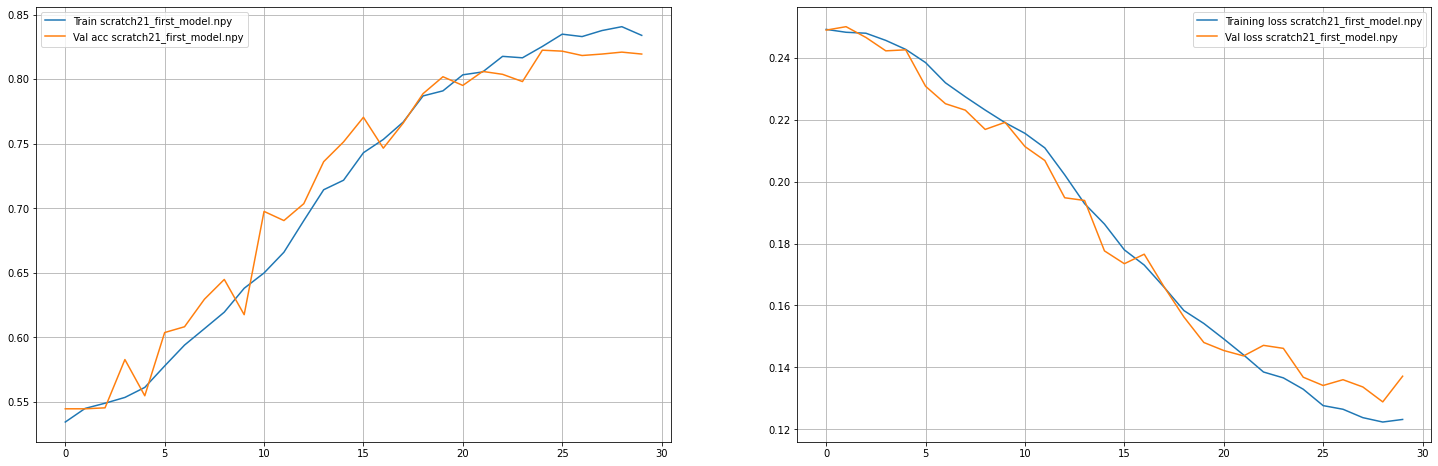

In [ ]:
trainerNtimes(times2run_trainer, genFirstModel, None, img, labels_train, 
              learning_rate, k, EPOCH, BATCH, save_model, 
              os.path.join(metrics_path, "scratch21_first_model.npy"))
PlotFiles(("scratch21_first_model.npy", None))

#Second Model
The first model was slow, but performance good. After playing with the number of layers and kernels, the second model has shown promising results, but the learning rate has to be way smaller, otherwise the network seems stuck in a valley by bouncing the accuracy and loss across several folds.

In [ ]:
learning_rate = 0.00007

In [ ]:
def genSecondModel(arg):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(40, (3, 3), activation='relu', input_shape=(width, height, 1), padding='same', strides=2))
  model.add(layers.BatchNormalization())  
  model.add(layers.MaxPooling2D(2, padding='same'))
  
  model.add(layers.Conv2D(160, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(2))
  
  model.add(layers.Conv2D(640, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(2, padding='same'))

  model.add(layers.Conv2D(640*4, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(2, padding='same'))

  model.add(layers.Flatten())
  model.add(layers.Dense(75, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.summary()
  return model    

##Training

[RUNNING@ 0 ] with arg None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 40)        400       
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 40)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 38, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 160)       57760     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 160)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 640)       922240    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:127: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

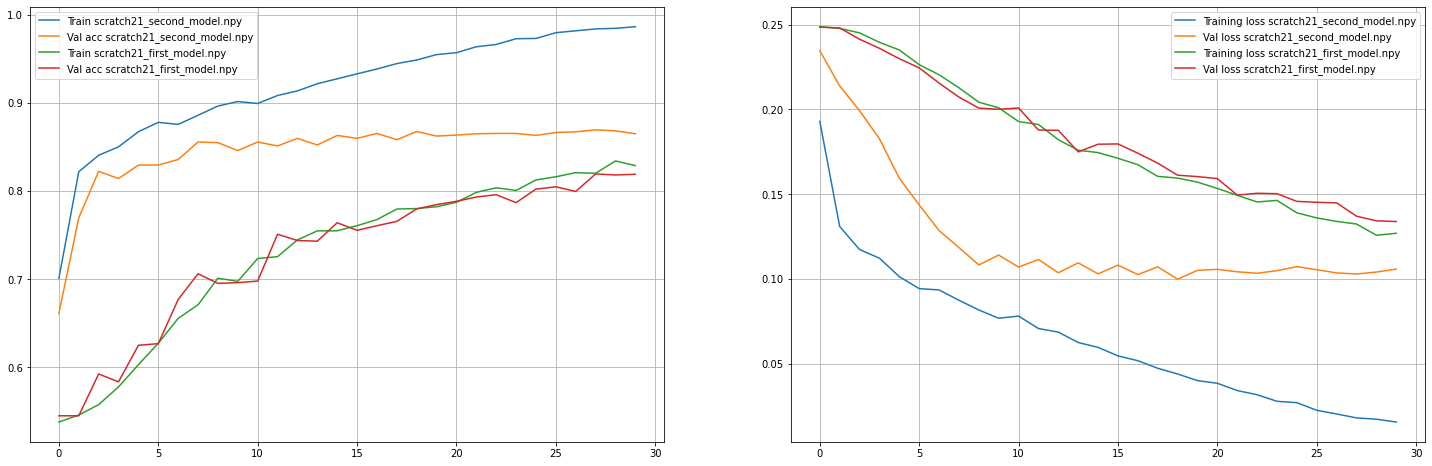

In [ ]:
trainerNtimes(times2run_trainer, genSecondModel, None, img, labels_train, 
              learning_rate, k, EPOCH, BATCH, save_model, 
              os.path.join(metrics_path, "scratch21_second_model.npy"))
PlotFiles(("scratch21_second_model.npy", "scratch21_first_model.npy"))

##Augmented Data
The number of samples presented is limited; hence, the network might have problems generalizing. To increase the data variety the ImageGenerator function has been used and it was expected to gain a bigger performance 

[RUNNING@ 0 ] with arg None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 40)        400       
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 40)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 38, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 160)       57760     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 160)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 640)       922240    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:127: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

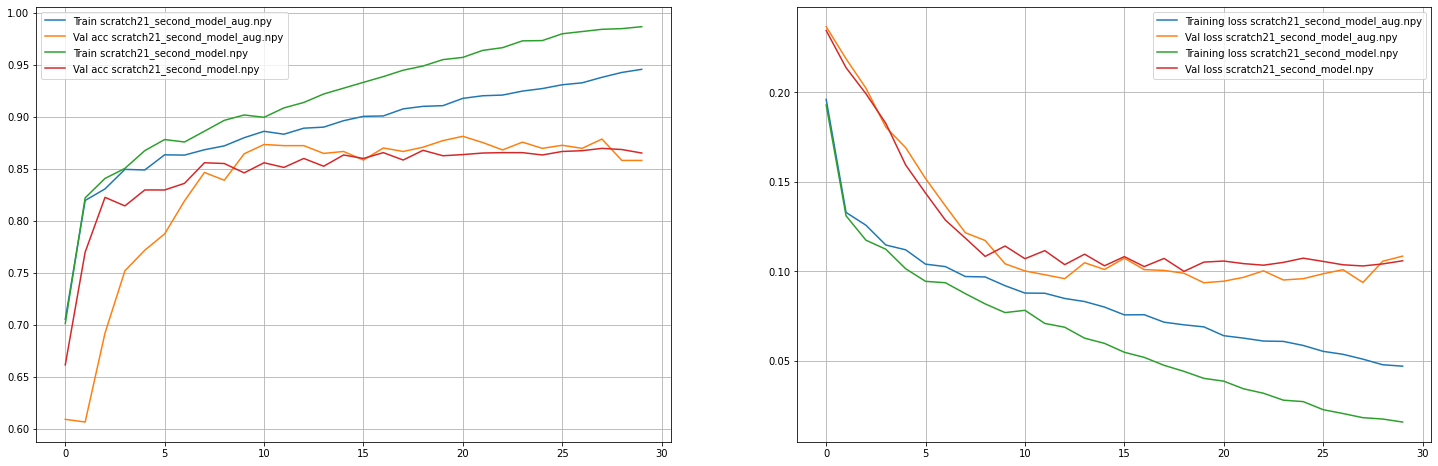

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, 0, genSecondModel, None, 
                                      img, labels_train, learning_rate, k, EPOCH, BATCH, 
                                      save_model, os.path.join(metrics_path, "scratch21_second_model_aug"))
PlotFiles(("scratch21_second_model_aug.npy", "scratch21_second_model.npy"))

#Validation Confusion Matrix
The performance of a network measured only by accuracy isnt enough, that's why the confusion matrix of Second Model with and without augmented data at training stage is compared

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def trainModel_w_kFold_n_confusion_mm(model, img, labels_train, optmz, kFold, epoch, batch_size, model_name):
  # Implements k-fold algorithm , and returns a normalized confusion matrix
  depth, _, _, _ = img.shape;
  chunk = depth // kFold

  idx = np.arange(depth);
  np.random.shuffle(idx);

  val_acc = 0.
  # Model
  model.compile(optimizer = optmz, loss="mse")
  model.save_weights(base_path+'task21_scratch_cm.h5')

  # Confusion Matrix 
  cmm = np.zeros([2, 2])

  for fold in range(kFold):
    print('START,',fold+1,'/',kFold,'--------------------------------------------------------------------------------')
    
    valid = idx[fold * chunk : (fold + 1) * chunk];
    train = np.concatenate((idx[:fold * chunk], idx[(fold + 1) * chunk:]), axis=0)
    model.load_weights(base_path+'task21_scratch_cm.h5');
        
    # Training
    model.fit(img[train], labels_train[train], epochs=epoch, batch_size=batch_size, verbose=0)    
    
    # Validation Confusion Matrix computation
    aux = model.predict(img[valid])
    y_pred = np.zeros(aux.shape)
    y_pred[aux >= 0.5] = 1
    cmm = cmm + confusion_matrix(labels_train[valid], y_pred, [0, 1])
    val_acc = val_acc + accuracy_score(labels_train[valid], y_pred)

    print('=> val acc:', accuracy_score(labels_train[valid], y_pred))
    print('DONE------------------------------------------------------------------------------------------')
    
    # Saving trained values
    if (fold == kFold - 1):
      model.save(model_name[:-3]+'_model.h5')
    
    #reset_weights(model)

  cmm_norm = np.sum(cmm)
  
  print("Overall val_acc: ", val_acc / (1.*kFold))
  
  return cmm/cmm_norm, val_acc / (1.*kFold)

def trainerNtimes_confusion_mm(n_times, genModelx, arg, img, labels_train, lr, k, EPOCH, BATCH, saveIt, fileName):
  # the trainer can call k-fold algorithm may times
  cmm = []
  val_acc = []

  # Notifier
  BotNotifier("Starting Scratch_21 with " + str(arg))


  for x in range(n_times):
    print('[RUNNING@',x,'] with arg',arg)
    backend.clear_session()

    # Optimizer and model
    adam = Adam(lr=lr);
    model = genModelx(arg);

    # calls k-fold algorithm
    a, b = trainModel_w_kFold_n_confusion_mm(model, img, labels_train, adam, k, EPOCH, BATCH, fileName)
    
    # release memory
    del model
    del adam

    # log metrics
    cmm.append(a)
    val_acc.append(b)

  # Average metrics
  cmm = np.average(cmm, axis=0)
  val_acc = np.average(val_acc, axis=0)

  # Save metrics
  if (saveIt): 
    np.save(fileName, np.stack(cmm))

  # Notifies, training is done
  BotNotifier("Done on Scratch_21 with " + str(arg))

  return cmm, val_acc


def trainModel_w_kFold_n_aug_confusion_mm(model, img, labels_train, optmz, kFold, epoch, batch_size, model_name):
  # Implements k-fold algorithm with aumented data and confusion matrix
  depth, _, _, _ = img.shape;
  chunk = depth // kFold

  idx = np.arange(depth);
  np.random.shuffle(idx);

  # Generator
  train_datagen = ImageDataGenerator(zoom_range=0.2)
  
  # Model
  model.compile(optimizer = optmz, loss="mse")
  model.save_weights(base_path+'task21_scratch_gen_cm.h5')

  # Metrics initialization
  val_acc = 0.0  
  cmm = np.zeros([2, 2])

  for fold in range(kFold):
    print('START,',fold+1,'/',kFold,'--------------------------------------------------------------------------------')
    
    # k-fold
    valid = idx[fold * chunk : (fold + 1) * chunk];
    train = np.concatenate((idx[:fold * chunk], idx[(fold + 1) * chunk:]), axis=0)
    
    # Generator
    train_generator = train_datagen.flow(img[train], labels_train[train], batch_size=batch_size)

    model.load_weights(base_path+'task21_scratch_gen_cm.h5')

    # train 1-fold
    model.fit(train_generator, steps_per_epoch=np.ceil(train.shape[0]/batch_size), 
              epochs=epoch, verbose=0)
    
    # Validation Confusion Matrix computation
    aux = model.predict(img[valid])
    y_pred = np.zeros(aux.shape)
    y_pred[aux >= 0.5] = 1
    cmm = cmm + confusion_matrix(labels_train[valid], y_pred, [0, 1])
    val_acc = val_acc + accuracy_score(labels_train[valid], y_pred)

    print('=> val acc:', accuracy_score(labels_train[valid], y_pred))
    print('DONE------------------------------------------------------------------------------------------')

    # Saving trained values
    #if (fold == kFold - 1):
      #print('Model Save at:', model_name+'_model.h5')
      #model.save(model_name+'_model.h5')
    
    #reset_weights(model)

  cmm_norm = np.sum(cmm)
  
  print("Overall val_acc: ", val_acc / (1.*kFold))
  
  return cmm/cmm_norm, val_acc / (1.*kFold)

def trainerNtimes_generator_confusion_mm(n_times, starts_in, genModelx, arg, img, labels_train, lr, k, EPOCH, BATCH, saveIt, fileName):
  # The k-fold algorithm with augmented data and confusin matrix as metrics can run many times 

  # Metrics storage
  cmm = [] # confusion metrics
  val_acc = [] # validation

  # Notifier, the trainins has started
  BotNotifier("Starting Scratch21 with " + str(arg))

  for x in range(n_times):
    print('[RUNNING@',x,'] with arg',arg)
    backend.clear_session()

    # Generatte model and optimizer
    adam = Adam(lr=lr);
    model = genModelx(arg);

    # Run kfold algorithm
    a, b = trainModel_w_kFold_n_aug_confusion_mm(model, img, labels_train, adam, k, EPOCH, BATCH, fileName)
    
    # Release memory
    del model
    del adam

    # Deprecated function
    #starts_in = starts_in + 1

    # log metrics
    cmm.append(a)
    val_acc.append(b)

  # average metrics
  cmm = np.average(cmm, axis=0)
  val_acc = np.average(val_acc, axis=0)

  # save metrics
  if (saveIt): 
    np.save(fileName, np.stack(cmm))

  # notify, the training finished
  BotNotifier("Done on Scratch_21 with " + str(arg))

  return cmm, val_acc


def plot_confusion_matrix(cm, num_classes, labels, title='Confusion matrix', cmap=plt.cm.Greys):
  # Plot n confusion matrices in a nx2 subplots
  rows = np.ceil(len(cm)/2)
  cm_idx = 1
  cols = 2

  plt.figure(figsize=(15, rows*6))

  for files in cm:
    if files is not None:
      cm_i = np.load(os.path.join(metrics_path, files))
      plt.subplot(rows, cols, cm_idx)
      plt.imshow(cm_i, interpolation='nearest', cmap=cmap)
      plt.title(files)
      plt.colorbar()
      tick_marks = np.arange(num_classes)
      plt.xticks(tick_marks, labels)
      plt.yticks(tick_marks, labels)
      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      print(files)
      print("=>", cm_i, "\n")

      cm_idx += 1

  plt.show() 

## Control Confusion Matrix 

The ideal classifier will predict the classes 100% correctly, this ideal classifier can be desribed by an ideal confusion matrix plotted:

scratch21_control_cm.npy
=> [[0.45515695 0.        ]
 [0.         0.54484305]] 



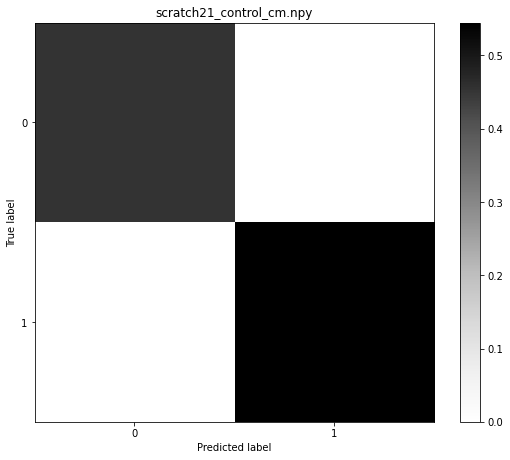

In [ ]:
cmm = confusion_matrix(labels_train, labels_train)
cmm = cmm/np.sum(cmm)
np.save(os.path.join(metrics_path, "scratch21_control_cm.npy"), np.stack(cmm))
plot_confusion_matrix(("scratch21_control_cm.npy", None), 2, [0, 1])

The epochs where the models reached the minimun loss are different, that's why the training will be carried out only until this epochs, techinique called early stopping.

In [ ]:
EPOCH = 18 # Second Model without augmented data
EPOCH_AUG = 19 # Second Model WITH augmented data

Training the Second Model without augmented data

In [ ]:
trainerNtimes_confusion_mm(times2run_trainer, genSecondModel, None, img, labels_train, 
              learning_rate, k, EPOCH, BATCH, save_model, 
              os.path.join(metrics_path, "scratch21_second_model_cm.npy"))

[RUNNING@ 0 ] with arg None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 40)        400       
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 40)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 38, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 160)       57760     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 160)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 640)       922240    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2

(array([[0.39775701, 0.05719626],
        [0.07028037, 0.47476636]]), 0.8725233644859813)

Training the Second Model WITH augmented data

In [ ]:
trainerNtimes_generator_confusion_mm(times2run_trainer, 0, genSecondModel, None, 
                                      img, labels_train, learning_rate, k, EPOCH_AUG, BATCH, 
                                      save_model, os.path.join(metrics_path, "scratch21_second_model_aug_cm"))

[RUNNING@ 0 ] with arg None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 40)        400       
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 40)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 38, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 160)       57760     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 160)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 640)       922240    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2

(array([[0.39738318, 0.05757009],
        [0.06280374, 0.48224299]]), 0.8796261682242991)

Comparing the confusion matrices, there's a slight advantage on the Second Model with augmented data at discriminating better Calcificacion classes; therefore, the Second Model will be trained with augmented data and submitted to test.

scratch21_control_cm.npy
=> [[0.45515695 0.        ]
 [0.         0.54484305]] 

scratch21_second_model_cm.npy
=> [[0.39775701 0.05719626]
 [0.07028037 0.47476636]] 

scratch21_second_model_aug_cm.npy
=> [[0.39738318 0.05757009]
 [0.06280374 0.48224299]] 



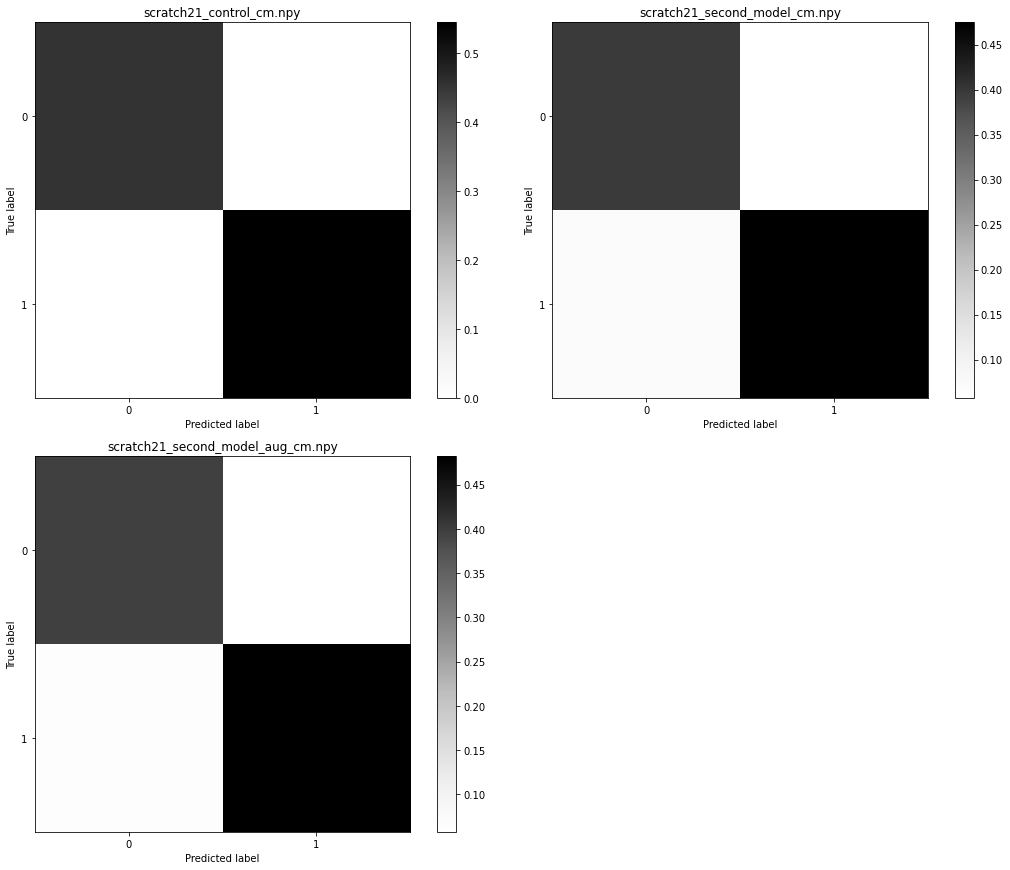

In [ ]:
plot_confusion_matrix(("scratch21_control_cm.npy", "scratch21_second_model_cm.npy", "scratch21_second_model_aug_cm.npy"), 2, [0, 1])

#Ultimate training
As mention above, the Second Model will be adopted because it shows better performance in terms of accuracy and learning speed, and precision at classifying Calcification.

In [ ]:
def train_only(modelFoo, lr, img, labels_train, epoch, batch_size, model2save):
  # Compile Model
  model = modelFoo(None)
  adam = Adam(lr=lr)
  model.compile(optimizer=adam, loss='mse')

  # Generator
  train_datagen = ImageDataGenerator(zoom_range=0.2)
  train_generator = train_datagen.flow(img, labels_train, batch_size=batch_size, shuffle=True)

  # Train
  model.fit(train_generator, steps_per_epoch=np.ceil(labels_train.shape[0]/batch_size), 
              epochs=epoch, verbose=1)
  # Save Model
  print('Model Save at:', base_path+weights2load+'_model.h5')
  model.save(base_path+weights2load+'_model.h5')

In [ ]:
train_only(genSecondModel, learning_rate, img, labels_train, 19, BATCH, "task21_scratch_gen_cm.h5")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 75, 75, 40)        400       
_________________________________________________________________
batch_normalization_8 (Batch (None, 75, 75, 40)        160       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 38, 38, 40)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 36, 36, 160)       57760     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 18, 18, 160)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 640)       922240    
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 8, 8, 640)        

#Test

##Load testing set

In [ ]:
img_test = np.load(base_path+'dataset/public_test_tensor.npy') 
labels = np.load(base_path+'dataset/public_test_labels.npy') 
depth_test, width_test, height_test = img_test.shape 

Pre-processing

In [ ]:
labels_test = np.array([]);
idx = [];

for i in range(depth_test):
  if ((labels[i] == 1) or (labels[i] == 2)): # mass
    idx.append(i)
    labels_test = np.append(labels_test, [0])

  elif ((labels[i] == 3) or (labels[i] == 4)): # calcification
    idx.append(i)
    labels_test = np.append(labels_test, [1]);

img_test = img_test[idx];
depth_test = idx.__len__()

Normalization

In [ ]:
img_test = img_test.reshape((depth_test, width_test, height_test, 1))
img_test = img_test.astype('float32') / 65535;

##Model Under Test

Loading model from a file

In [ ]:
mut = models.load_model(base_path+'models/task21_scratch_gen_cm.h5_model.h5')

Computing Metrics

In [ ]:
# Prediction
aux = mut.predict(img_test)
y_test = np.zeros(aux.shape)
y_test[aux >= 0.5] = 1

# COnfusion Matrix
cmm = confusion_matrix(labels_test, y_test)
cmm = cmm/np.sum(cmm)
# Save Test confusion matrix
np.save(os.path.join(metrics_path, "scratch21_test_cm.npy"), np.stack(cmm))

# Save y_test for task5: ensemble network
np.save(os.path.join(metrics_path, "scratch21_y_test_output_label.npy"), np.stack(aux))
print("ACCURACY TEST: ", accuracy_score(labels_test, y_test))

ACCURACY TEST:  0.8630952380952381


**Control Test Confusion Matrix**. The test data distribution is differente; so, it's not expected for a the network to have a similar validation confusion matrix. The expected confusion matrix should be the Confusion Matrix of an ideal classifier for test

In [ ]:
cmm = confusion_matrix(labels_test, labels_test)
cmm = cmm/np.sum(cmm)
np.save(os.path.join(metrics_path, "scratch21_test_control_cm.npy"), np.stack(cmm))

scratch21_control_cm.npy
=> [[0.45515695 0.        ]
 [0.         0.54484305]] 

scratch21_second_model_aug_cm.npy
=> [[0.39738318 0.05757009]
 [0.06280374 0.48224299]] 

scratch21_test_control_cm.npy
=> [[0.5327381 0.       ]
 [0.        0.4672619]] 

scratch21_test_cm.npy
=> [[0.46428571 0.06845238]
 [0.06845238 0.39880952]] 



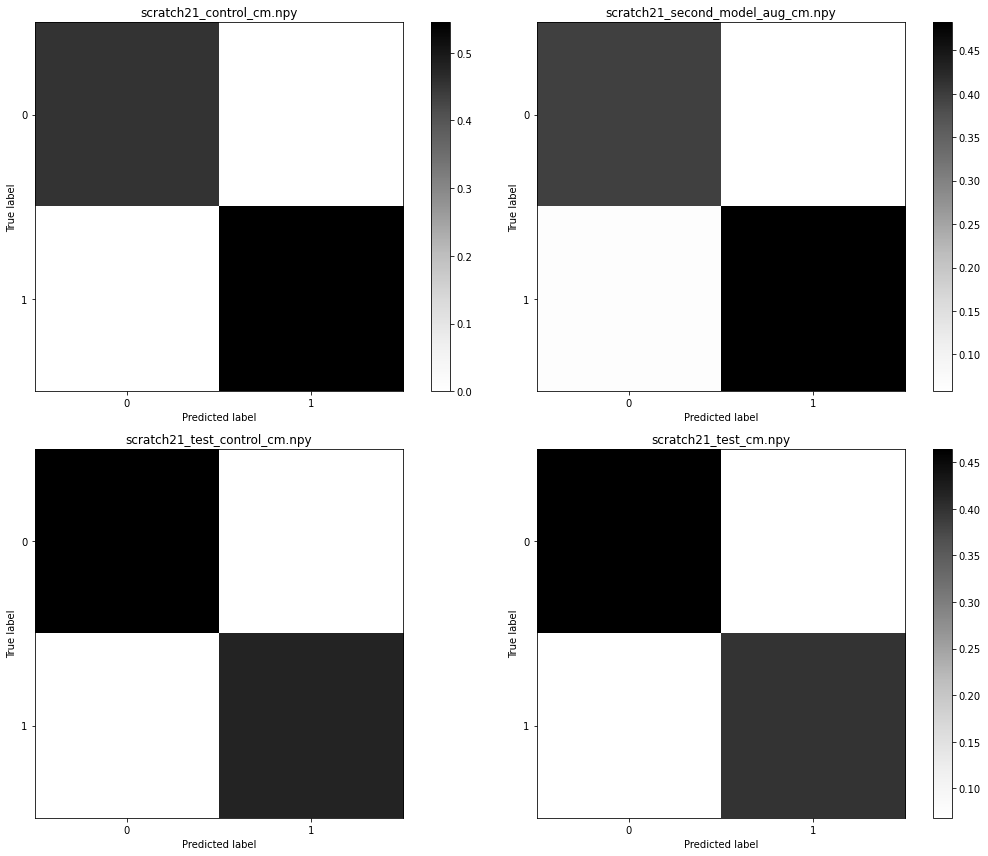

In [ ]:
plot_confusion_matrix(("scratch21_control_cm.npy", "scratch21_second_model_aug_cm.npy", "scratch21_test_control_cm.npy", "scratch21_test_cm.npy"), 2, [0, 1])